<a href="https://colab.research.google.com/github/Yuumna/GAN-PyTorch/blob/main/GAN(linear_batch_normalization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Adversarial Network - PyTorch**
This notebook contains implementation of normal linear GAN with batch normalization.

# Import Libraries

In [ ]:
#PyTorch dependencies
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(0)

# Download and Transform Data


In [ ]:
batch_size = 128

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#GAN Model

# Discriminator

In [ ]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
    '''
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True) #LeakyReLU activation
    )

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Adding one more linear map to transform the final output into a single value  
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)

# Generator


In [ ]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
      
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)




# Instantiate Models

In [ ]:
# If a gpu is available move all models to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#build the models
z_dim = 64
criterion = nn.BCEWithLogitsLoss()

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device) 

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

In [ ]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the c1urrent batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

    return gen_loss

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)
  

# **Training**

# optimizer

In [ ]:
lr = 0.00001 #learning_rate

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.3880884845256807, discriminator loss: 0.41926240515708924


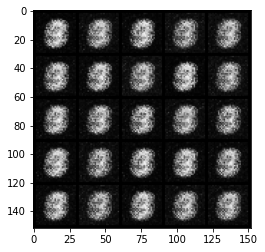

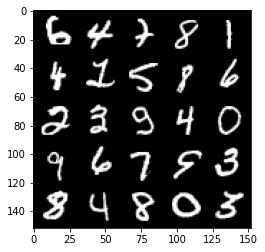

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.6689539303779604, discriminator loss: 0.300281394869089


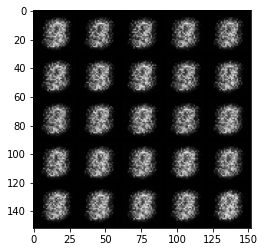

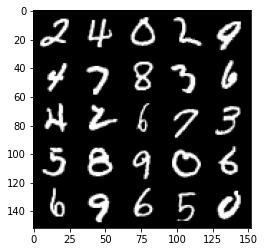

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.95938590836525, discriminator loss: 0.17414918056130413


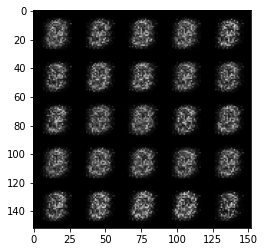

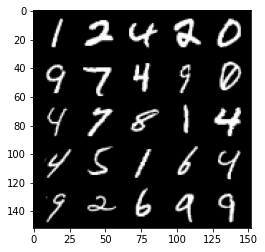

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.762011030912398, discriminator loss: 0.19570282945036888


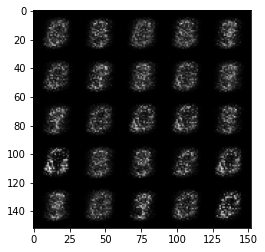

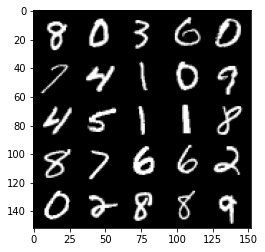

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.7257824044227597, discriminator loss: 0.1950421906411647


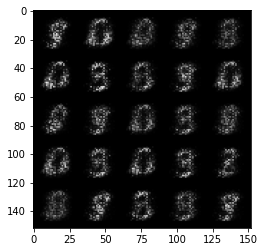

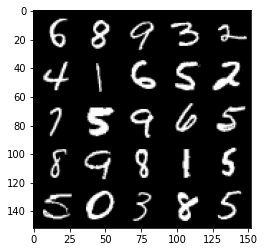

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.0246421701908117, discriminator loss: 0.15110561807453632


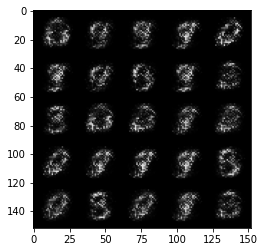

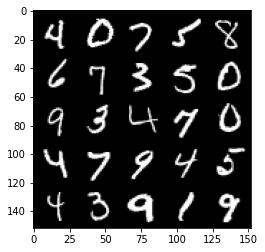

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.402495989322663, discriminator loss: 0.12575292137265198


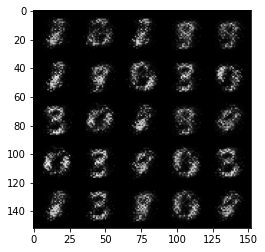

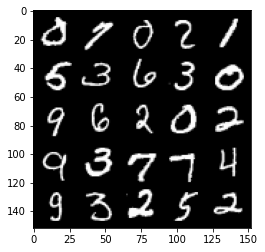

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.708540443420414, discriminator loss: 0.12425842255353918


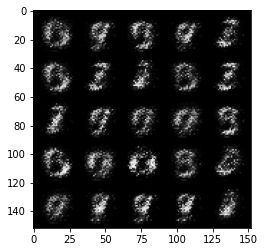

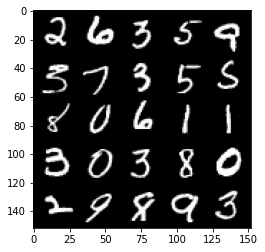

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 3.1932393455505372, discriminator loss: 0.09910749727487568


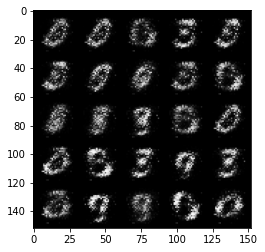

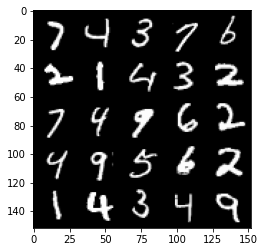

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.462725609302524, discriminator loss: 0.08028518027812241


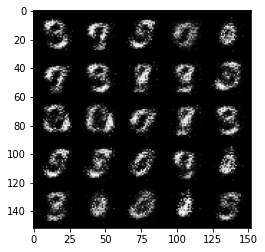

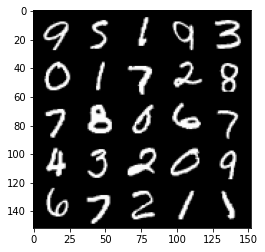

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.723095480442051, discriminator loss: 0.08071473077684645


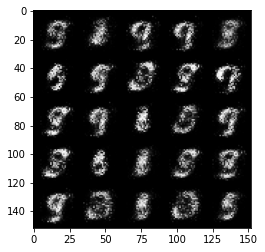

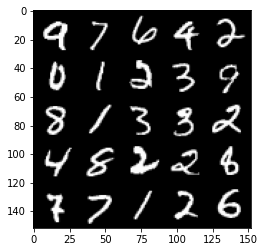

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.768851088047028, discriminator loss: 0.07765703515708448


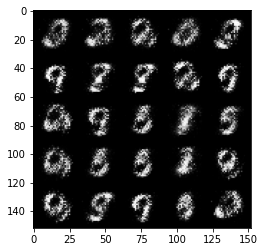

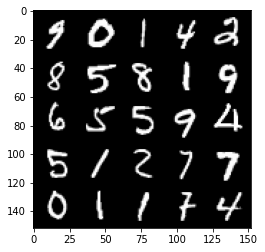

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 3.911275695800783, discriminator loss: 0.06285137159377337


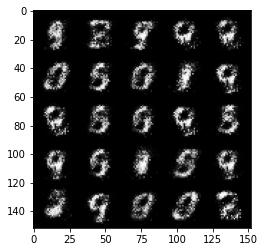

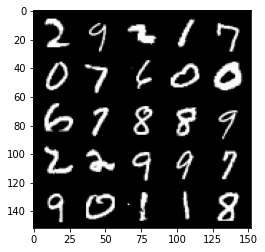

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 3.967547162532808, discriminator loss: 0.05255420549958946


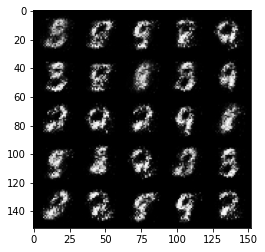

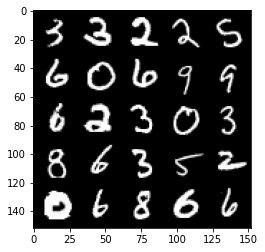

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 4.1512283306121835, discriminator loss: 0.04930347777158027


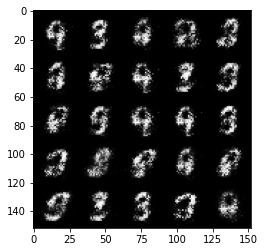

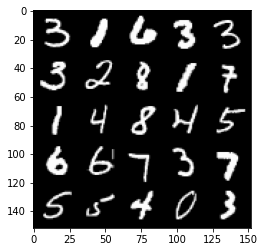

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 4.073897530078886, discriminator loss: 0.05724888779222965


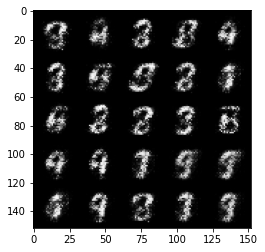

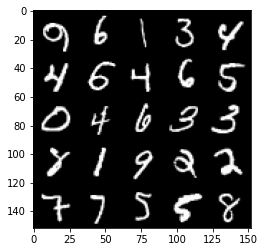

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 4.122386194705962, discriminator loss: 0.06101196127757426


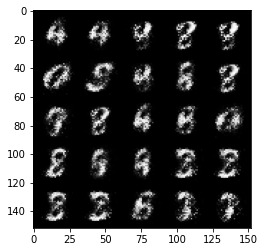

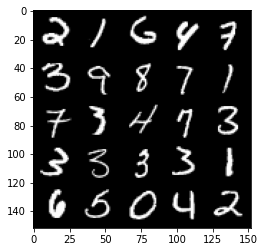

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 4.16623649692535, discriminator loss: 0.06029806819185612


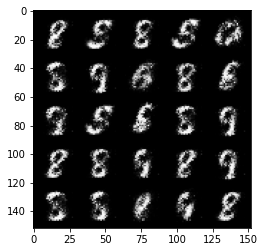

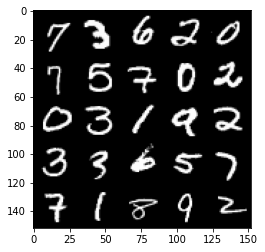

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 4.119968928337096, discriminator loss: 0.05957644879445429


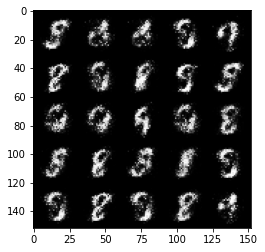

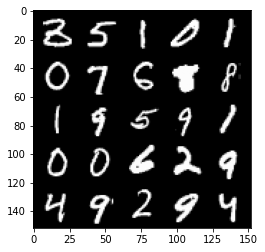

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 4.244474031925197, discriminator loss: 0.059203193508088565


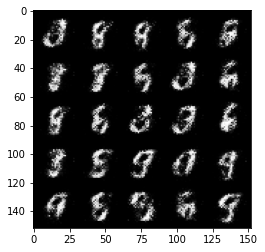

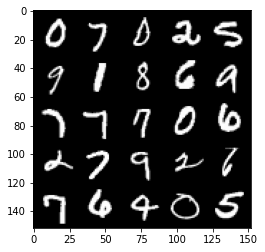

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 3.902140421390536, discriminator loss: 0.07442788165062669


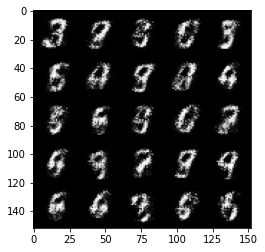

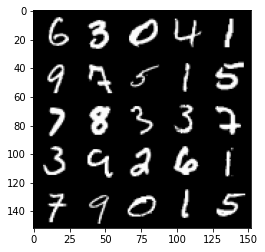

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 3.9658224759101883, discriminator loss: 0.06735667702555653


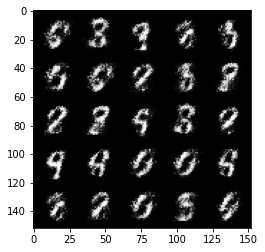

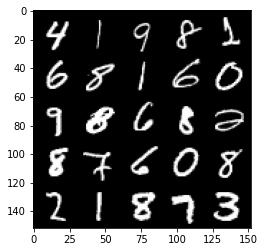

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 4.025352598667148, discriminator loss: 0.07044677222892641


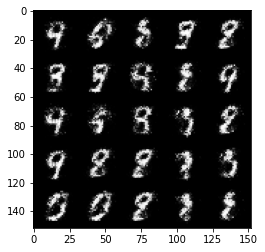

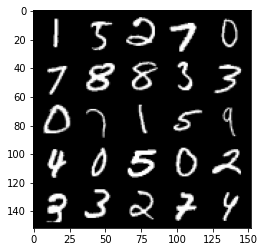

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 4.0395096950531, discriminator loss: 0.0850260739400983


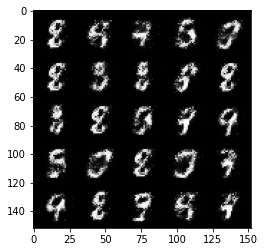

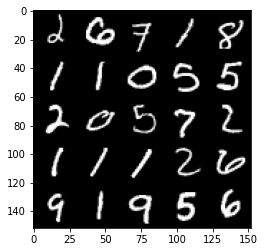

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 3.9486220259666474, discriminator loss: 0.091292193196714


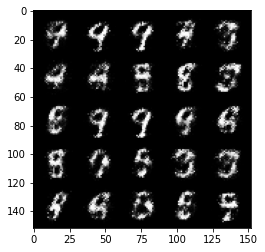

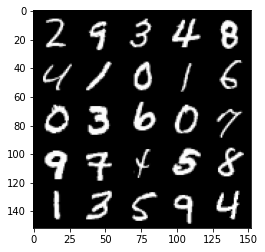

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 4.010304807186129, discriminator loss: 0.08543127749860294


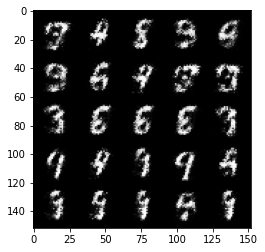

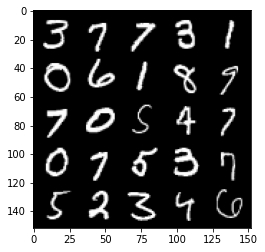

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 3.9822066583633426, discriminator loss: 0.07945214689522982


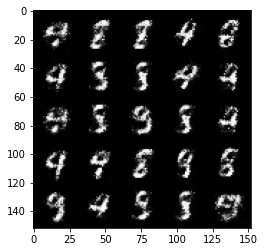

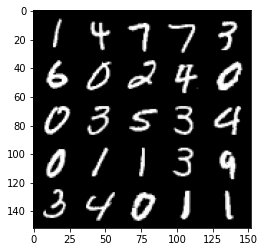

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 3.759059773921962, discriminator loss: 0.1028436610549688


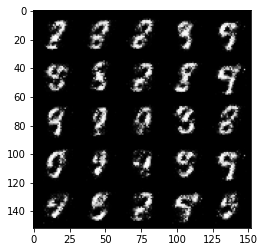

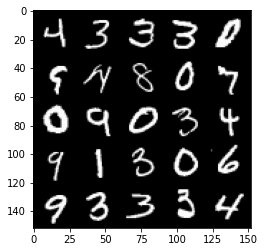

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 3.7419130654335055, discriminator loss: 0.10536010195314888


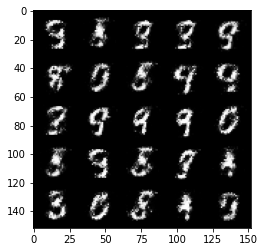

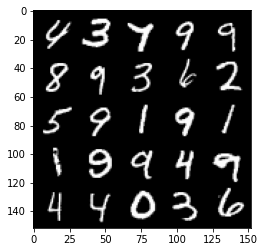

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 3.7817879161834727, discriminator loss: 0.10777027183026071


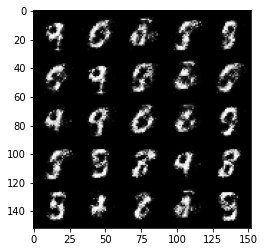

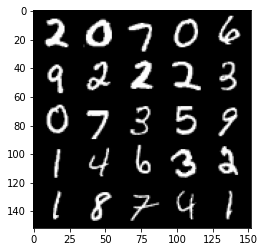

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 3.7671512842178343, discriminator loss: 0.12201950689405201


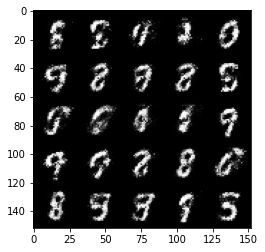

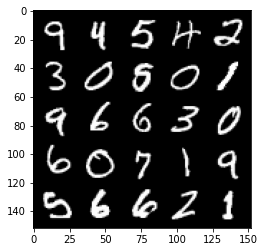

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 3.947630589008331, discriminator loss: 0.11066982344537966


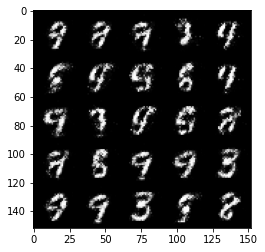

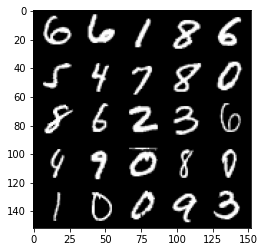

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 3.6423876032829274, discriminator loss: 0.12710204179584994


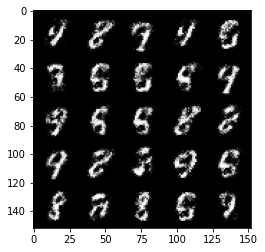

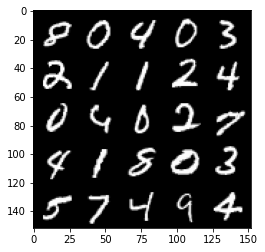

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 3.575123549461367, discriminator loss: 0.13793699866533277


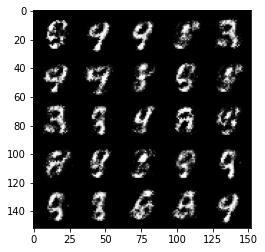

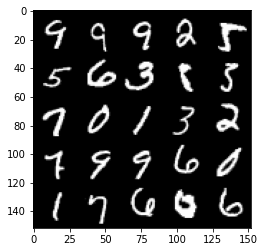

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 3.3331780195236225, discriminator loss: 0.14235700309276583


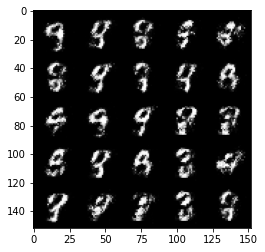

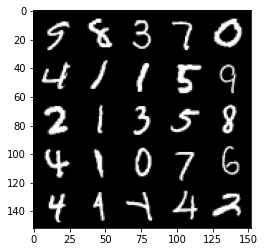

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 3.586038103580478, discriminator loss: 0.1329530052393675


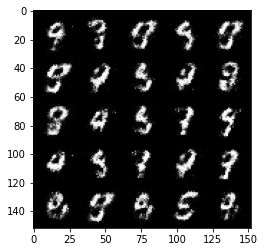

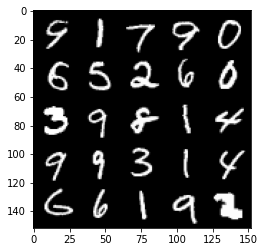

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 3.4438968758583073, discriminator loss: 0.14264883674681184


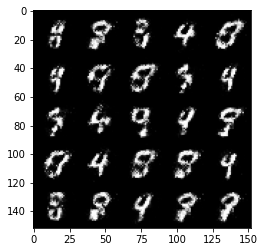

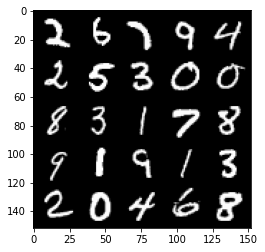

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 3.3023682246208215, discriminator loss: 0.14673197233676927


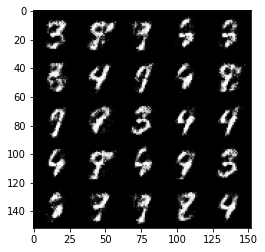

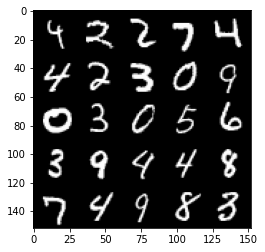

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 3.2857694225311267, discriminator loss: 0.14817554576694966


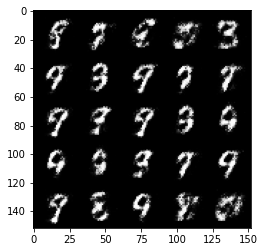

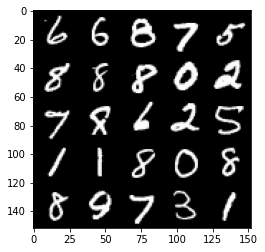

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 3.2350342350006103, discriminator loss: 0.1528819543719291


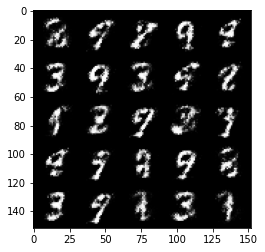

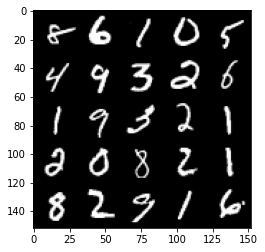

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 3.3436895136833207, discriminator loss: 0.14491789303719993


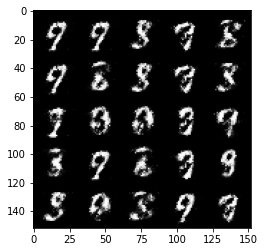

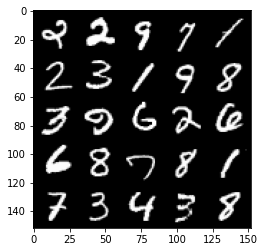

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 3.2512176322937045, discriminator loss: 0.15940673594176766


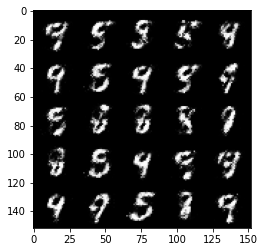

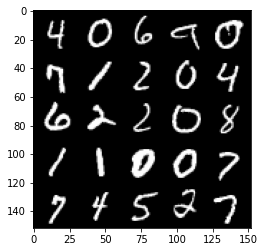

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 3.257864739894867, discriminator loss: 0.15845006257295605


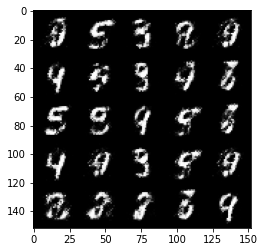

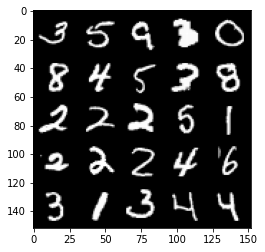

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 3.2446561870574926, discriminator loss: 0.1718734888583422


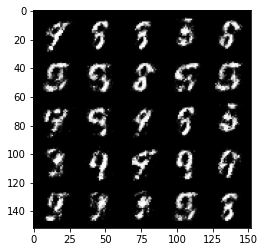

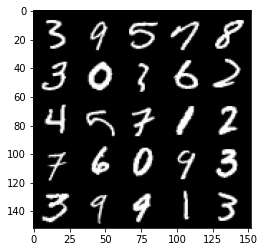

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 3.264501754760746, discriminator loss: 0.14970240439474583


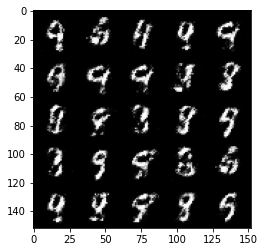

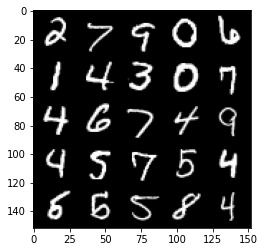

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 3.268028988838197, discriminator loss: 0.15079569673538218


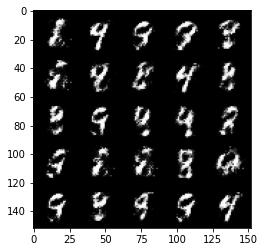

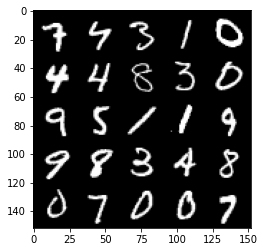

In [ ]:
n_epochs = 50
display_step = 500
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

# Keep track of losses
disc_losses = []
gen_losses = []

test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_losses.append(disc_loss.item())

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_losses.append(gen_loss.item())
        gen_loss.backward()
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


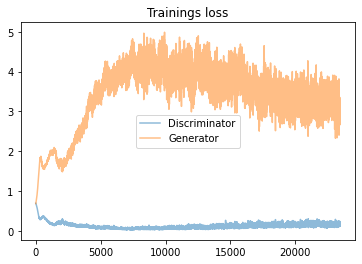

In [ ]:
plt.plot(disc_losses, label="Discriminator", alpha=0.5)
plt.plot(gen_losses, label="Generator", alpha=0.5)
plt.title("Trainings loss")
plt.legend()
plt.show()